In [2]:
# Cell 1: Import e caricamento dati
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("../data/processed/RM_Dimessi_clean.parquet")
print(f"✅ Dati caricati - {df.shape[0]} righe, {df.shape[1]} colonne")

✅ Dati caricati - 21141 righe, 140 colonne


In [3]:
# Cell 2: Definizione target (Barthel totale in dimissione)
barthel_cols_dim = [col for col in df.columns if col.startswith("bartdim")]

# Somma degli 11 item Barthel (0–100)
df["barthel_tot_dim"] = df[barthel_cols_dim].sum(axis=1, skipna=True)

# Rimuoviamo righe con target mancante
df = df[~df["barthel_tot_dim"].isna()]

In [4]:
# Cell 3: Feature selection iniziale (clinicamente interpretabile)
feature_cols = [
    "età del paziente dimesso",
    "sesso",
    "regime",
    "patriab",  # ICD9 CM principale
    "locomric",
    "respirric",
    "contrsfinric",
    "nutrric",
    "trachric",
    "postcomric",
    "mieloric",
]

X = df[feature_cols].copy()
y = df["barthel_tot_dim"]

In [5]:
# Cell 4: Preprocessing: encoding variabili categoriche
# Convertiamo tutte le colonne object/string in numerico via one-hot
X = pd.get_dummies(X, drop_first=True)

# Rimuoviamo eventuali righe con NaN rimasti
X = X.dropna()
y = y.loc[X.index]

In [6]:
# Cell 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"✅ Split completato - Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

✅ Split completato - Train: 16908, Test: 4228


In [7]:
# Cell 6: Regressione con XGBoost
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Valutazione
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🎯 R2: {r2:.3f} | MAE: {mae:.2f}")

🎯 R2: 0.233 | MAE: 18.70


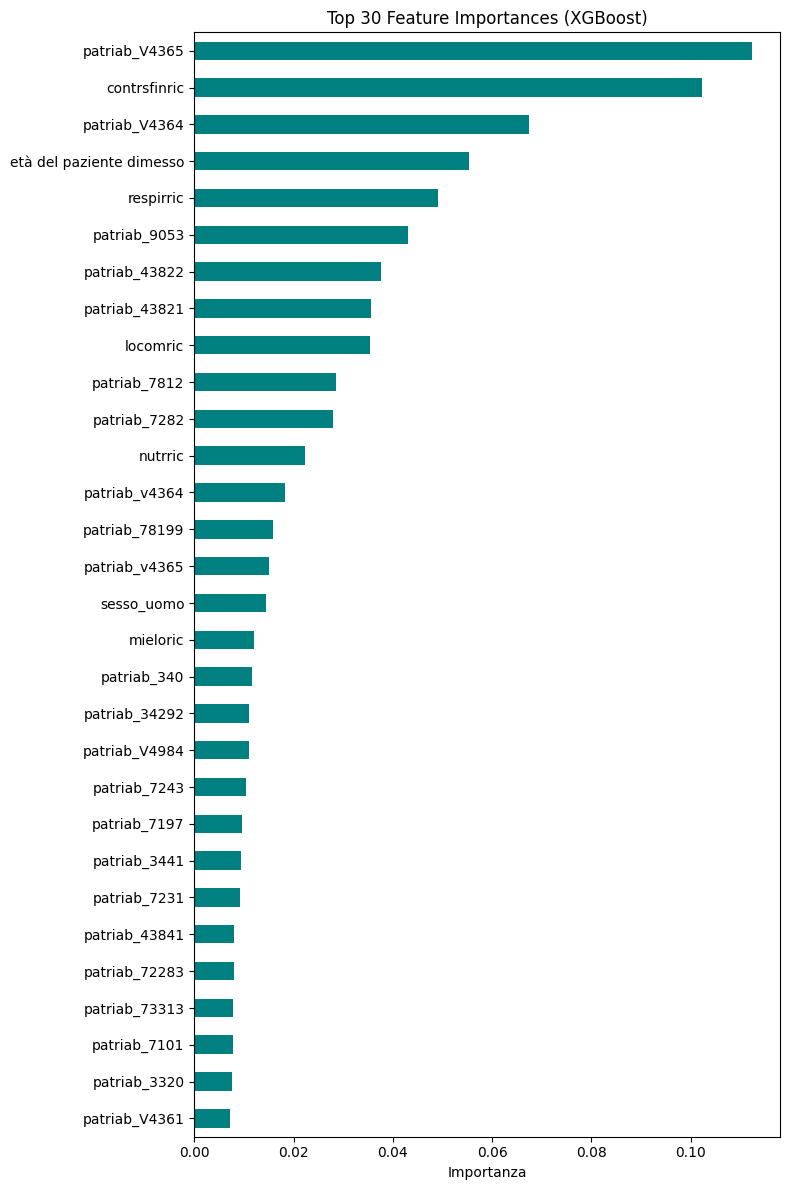

In [9]:
# Cell 7: Feature importance leggibile

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True).tail(30)  # mostra solo le top 30

plt.figure(figsize=(8, 12))
importances.plot(kind='barh', color='teal')
plt.title("Top 30 Feature Importances (XGBoost)")
plt.xlabel("Importanza")
plt.tight_layout()
plt.show()

POTENZIAMO XGBOOST REGRESSOR

In [10]:
# Cell 8: Calcolo Barthel in ingresso
barthel_cols_ing = [col for col in df.columns if col.startswith("bartric")]
df["barthel_tot_ing"] = df[barthel_cols_ing].sum(axis=1, skipna=True)

# Filtra righe con target e Barthel ingresso validi
df = df[~df["barthel_tot_dim"].isna() & ~df["barthel_tot_ing"].isna()]

In [11]:
# Cell 9: Feature set potenziato
feature_cols_ext = [
    "età del paziente dimesso",
    "sesso",
    "regime",
    "patriab",  # ICD9 CM principale
    "locomric",
    "respirric",
    "contrsfinric",
    "nutrric",
    "trachric",
    "postcomric",
    "mieloric",
    "barthel_tot_ing",  # 🔥 nuova variabile chiave
]

X = df[feature_cols_ext].copy()
y = df["barthel_tot_dim"]

In [12]:
# Cell 10: Encoding e split
X = pd.get_dummies(X, drop_first=True)
X = X.dropna()
y = y.loc[X.index]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
# Cell 11: Regressione XGBoost aggiornata
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🎯 R² aggiornato: {r2:.3f} | MAE: {mae:.2f}")

🎯 R² aggiornato: 0.274 | MAE: 17.45


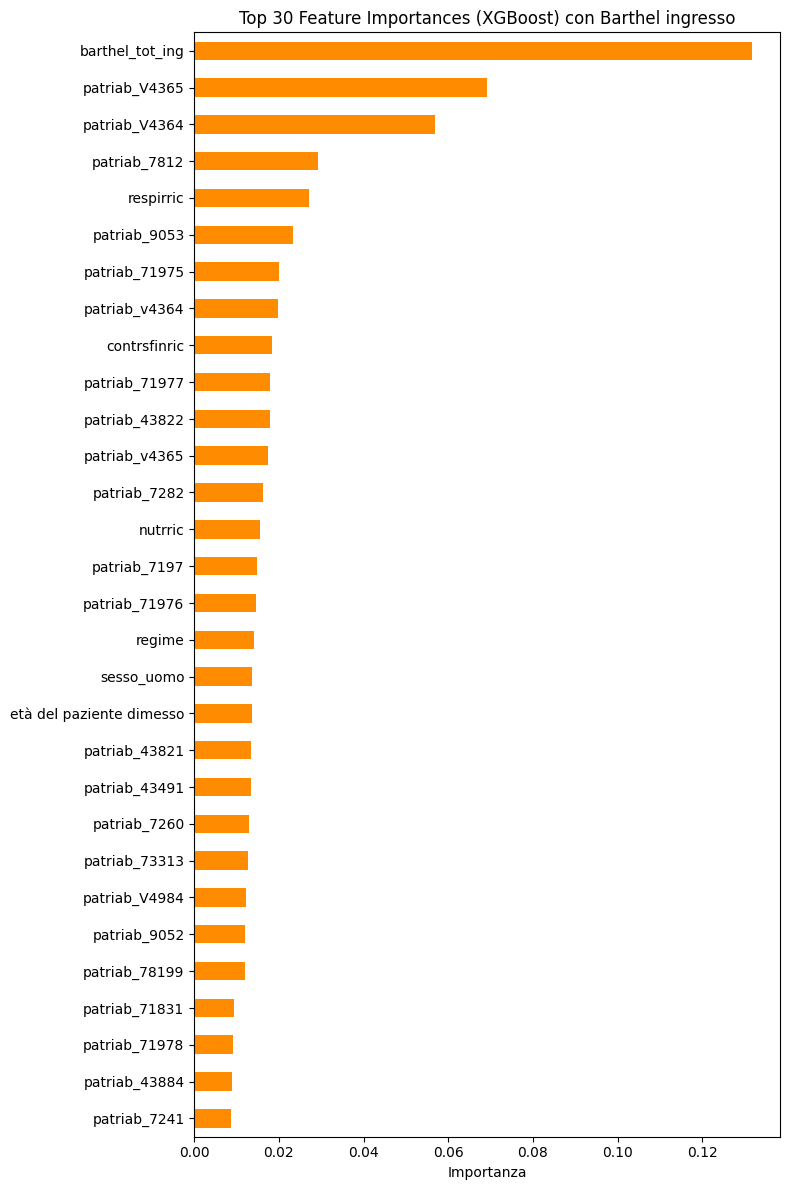

In [14]:
# Cell 12: Nuovo grafico delle importanze
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True).tail(30)

plt.figure(figsize=(8, 12))
importances.plot(kind='barh', color='darkorange')
plt.title("Top 30 Feature Importances (XGBoost) con Barthel ingresso")
plt.xlabel("Importanza")
plt.tight_layout()
plt.show()

### ICD9 grouping intelligente

In [15]:
# Cell 13: Funzione per raggruppare codici ICD9

def map_icd9_group(code):
    try:
        if pd.isna(code):
            return "unknown"

        code_str = str(code).strip().upper()

        if code_str.startswith("V43"):
            return "Protesi articolare"
        elif code_str.startswith("V"):
            return "Altro V-code"
        elif code_str.startswith("43"):
            return "Cerebrovascolare"
        elif code_str.startswith("72"):
            return "Disturbi articolari"
        elif code_str.startswith("78"):
            return "Sintomi neurologici"
        elif code_str.startswith("34"):
            return "Sclerosi Multipla"
        elif code_str.startswith("33"):
            return "Lesioni midollari"
        elif code_str.startswith("71"):
            return "Fratture arto inferiore"
        elif code_str.startswith("90"):
            return "Esiti chirurgici"
        elif code_str.startswith("74"):
            return "Artroprotesi anche-ginocchio"
        elif code_str.startswith("32"):
            return "Paralisi cerebrale infantile"
        elif code_str.startswith("38"):
            return "Polineuropatie"
        elif code_str.startswith("77"):
            return "Traumatismi vari"
        else:
            return "Altre diagnosi"
    except:
        return "invalid"

# Applica mappa
df["patriab_group"] = df["patriab"].apply(map_icd9_group)

In [16]:
# Cell 14: Nuovo feature set con raggruppamento ICD9

feature_cols_grp = [
    "età del paziente dimesso",
    "sesso",
    "regime",
    "patriab_group",  # nuova variabile categoriale raggruppata
    "locomric",
    "respirric",
    "contrsfinric",
    "nutrric",
    "trachric",
    "postcomric",
    "mieloric",
    "barthel_tot_ing",
]

X = df[feature_cols_grp].copy()
y = df["barthel_tot_dim"]

In [17]:
# Cell 15: Encoding e split
X = pd.get_dummies(X, drop_first=True)
X = X.dropna()
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
# Cell 16: Nuovo modello
model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🎯 R² con ICD9 grouping: {r2:.3f} | MAE: {mae:.2f}")

🎯 R² con ICD9 grouping: 0.276 | MAE: 17.39


### A questo punto procederei con Delta Barthel..